# Tangram with cell numbers


Make mock prediction on number of cells per spot based on number of features per spot and run tangram.

Run for all the samples in one go, do not really need the images...

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import os,sys

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


# Add in ST data

Load anndata object with ST data

In [23]:
adata_st = sc.read_h5ad("../../../spatial/results/all/all_harmony.h5ad")

In [24]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index
adata_st = adata_st.raw.to_adata()

AttributeError: 'NoneType' object has no attribute 'var'

In [25]:
sc.pp.calculate_qc_metrics(adata_st, percent_top=None, log1p=False, inplace=True)


In [26]:
# make mock cell counts ranging from 0,40
nF = adata_st.obs["n_genes_by_counts"]
nCell = round((nF - min(nF))/max(nF) * 40) 
nCell.value_counts()

1.0     6387
2.0     3497
0.0     3454
3.0     2207
4.0     1397
5.0     1057
6.0      811
7.0      692
8.0      614
9.0      584
10.0     479
11.0     397
12.0     348
13.0     321
14.0     265
17.0     224
16.0     219
15.0     212
18.0     182
19.0     159
21.0     142
20.0     141
24.0     120
23.0     117
22.0     106
25.0      82
26.0      79
27.0      74
28.0      67
29.0      66
30.0      62
31.0      44
33.0      34
32.0      34
34.0      22
35.0       8
36.0       3
37.0       2
38.0       2
40.0       1
Name: n_genes_by_counts, dtype: int64

In [27]:
adata_st.obs["cell_count"]=nCell

Predicted number of cells vs counts/genes

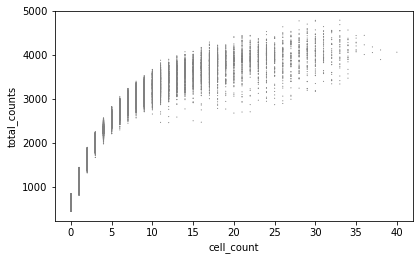

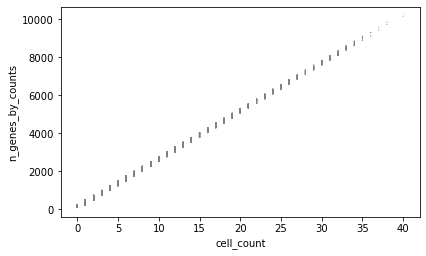

In [29]:
sc.pl.scatter(adata_st, "cell_count", "total_counts")
sc.pl.scatter(adata_st, "cell_count", "n_genes_by_counts")

## Load SC data


In [15]:
input_dir = "../../../deconv/inputs/"
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [16]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index

In [17]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()

In [30]:
deg_path = os.path.join(input_dir, "sc_data", "degs_fc0.5_pval0.01.txt")
genes = pd.read_csv(deg_path, header=None) 

In [31]:
print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])

0    5121
dtype: int64
0    5121
dtype: int64


## Run Tangram 

In [32]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:5121 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:24514 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [33]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5121 genes and customized density_prior in constrained mode...


Score: 0.289, KL reg: 0.664, Count reg: 114590.859, Lambda f reg: 1887.625
Score: 0.383, KL reg: 0.015, Count reg: 110056.219, Lambda f reg: 60.783
Score: 0.400, KL reg: 0.005, Count reg: 110019.195, Lambda f reg: 24.129
Score: 0.406, KL reg: 0.002, Count reg: 110008.641, Lambda f reg: 13.619
Score: 0.409, KL reg: 0.002, Count reg: 110003.953, Lambda f reg: 8.948
Score: 0.410, KL reg: 0.001, Count reg: 110001.414, Lambda f reg: 6.409
Score: 0.411, KL reg: 0.001, Count reg: 109999.852, Lambda f reg: 4.852
Score: 0.412, KL reg: 0.001, Count reg: 109998.828, Lambda f reg: 3.819
Score: 0.412, KL reg: 0.001, Count reg: 109998.102, Lambda f reg: 3.094
Score: 0.413, KL reg: 0.001, Count reg: 109997.562, Lambda f reg: 2.562


INFO:root:Saving results..


In [34]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [35]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [36]:
celltypes = adata_sc.obs['cl.annot'].unique()
celltypes = sorted(celltypes)



In [37]:
adata_st

AnnData object with n_obs × n_vars = 24712 × 27278
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'NGI_ID', 'Patient', 'Gender', 'Age', 'Seq_Batch', 'Condition', 'Donor', 'Sample_name', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_malat1', 'nFeature_noMT', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'Score_FB.1', 'Score_FB.2', 'Score_FB.3', 'Score_KC.1', 'Score_KC.2', 'Score_KC.3', 'Score_LEC', 'Score_MAC.DC', 'Score_MEL_NC_SC', 'Score_PC.vSMC', 'Score_SGC', 'Score_TC', 'Score_VEC.1', 'Score_VEC.2', 'SCT_snn_res.1', 'CelltypeCluster', 'individual_clust', 'donor_clust', 'CelltypeClusterDint', 'CelltypeClusterInt', 'n_genes_by_counts', 'total_counts', 'cell_count', 'uniform_density', 'rna_count_based_density', 'Th', 'Basal-I', 'DC', 'FB-II', 'LE', 'MEL', 'Mast-cell', 'Mac', 'Granular-II', 'FB-III', 'Mono-Mac', 'Spinous-II', 'Mono-DC', 'Granular-I', 'PC-vSMC', 'FB-IV', 'FB-I', 'LC', 'Spinous-I', 'B-cell', 'Basal-II', 'VE', 'NK-cell', 'Spinou

In [38]:
# convert to cell numbers, will not work without the tangram image_features
# adata_st.obsm['image_features'], with 
# segmentation_label, segmentation_centroid

centroids = [ [[1.1,2.2]] * int(adata_st.obs["cell_count"][i]) for i in range(adata_st.n_obs)]


imfeats = pd.DataFrame({"segmentation_label" : adata_st.obs["cell_count"].astype("int"), "segmentation_centroid" : centroids })
imfeats

,segmentation_label,segmentation_centroid
AAACAAGTATCTCCCA-1_1,3,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2]]"
AAACATTTCCCGGATT-1_1,1,"[[1.1, 2.2]]"
AAACCTAAGCAGCCGG-1_1,14,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
AAACGAGACGGTTGAT-1_1,2,"[[1.1, 2.2], [1.1, 2.2]]"
AAACGGGCGTACGGGT-1_1,1,"[[1.1, 2.2]]"
...,...,...
TTGTGTTTCCCGAAAG-1_16,4,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2]]"
TTGTTAGCAAATTCGA-1_16,8,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
TTGTTCAGTGTGCTAC-1_16,8,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
TTGTTGTGTGTCAAGA-1_16,1,"[[1.1, 2.2]]"


In [39]:
imfeats['segmentation_centroid'] =  [[[]] if len(x) == 0 else x for x in imfeats['segmentation_centroid']]


In [40]:
#imfeats[imfeats.segmentation_label == 0]["segmentation_centroid"] = 5
imfeats

,segmentation_label,segmentation_centroid
AAACAAGTATCTCCCA-1_1,3,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2]]"
AAACATTTCCCGGATT-1_1,1,"[[1.1, 2.2]]"
AAACCTAAGCAGCCGG-1_1,14,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
AAACGAGACGGTTGAT-1_1,2,"[[1.1, 2.2], [1.1, 2.2]]"
AAACGGGCGTACGGGT-1_1,1,"[[1.1, 2.2]]"
...,...,...
TTGTGTTTCCCGAAAG-1_16,4,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2]]"
TTGTTAGCAAATTCGA-1_16,8,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
TTGTTCAGTGTGCTAC-1_16,8,"[[1.1, 2.2], [1.1, 2.2], [1.1, 2.2], [1.1, 2.2..."
TTGTTGTGTGTCAAGA-1_16,1,"[[1.1, 2.2]]"


In [41]:
adata_st.obsm['image_features'] = imfeats

In [42]:
tg.create_segment_cell_df(adata_st)

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


In [43]:
adata_st.uns["tangram_cell_segmentation"].head()

,spot_idx,y,x,centroids
0,AAACAAGTATCTCCCA-1_1,1.1,2.2,AAACAAGTATCTCCCA-1_1_0
1,AAACAAGTATCTCCCA-1_1,1.1,2.2,AAACAAGTATCTCCCA-1_1_1
2,AAACAAGTATCTCCCA-1_1,1.1,2.2,AAACAAGTATCTCCCA-1_1_2
3,AAACATTTCCCGGATT-1_1,1.1,2.2,AAACATTTCCCGGATT-1_1_0
4,AAACCTAAGCAGCCGG-1_1,1.1,2.2,AAACCTAAGCAGCCGG-1_1_0


In [83]:
# count_cell also needs the spatial slot as an array
df = pd.DataFrame(index = adata_st.obs.index, columns=['x','y'])
df['x'] = 1.1
df['y'] = 2.2
a = df.to_numpy()
adata_st.obsm["spatial"] = a


array([2.2, 2.2, 2.2, ..., 2.2, 2.2, 2.2])

In [84]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cl.annot",
)

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [85]:
adata_st.obsm["tangram_ct_count"].head()

,x,y,cell_n,centroids,Th,Basal-I,DC,FB-II,LE,MEL,...,LC,Spinous-I,B-cell,Basal-II,VE,NK-cell,Spinous-III,Basal-IV,Basal-III,Schwann
AAACAAGTATCTCCCA-1_1,2.2,1.1,3,"[AAACAAGTATCTCCCA-1_1_0, AAACAAGTATCTCCCA-1_1_...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTTCCCGGATT-1_1,2.2,1.1,1,[AAACATTTCCCGGATT-1_1_0],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AAACCTAAGCAGCCGG-1_1,2.2,1.1,14,"[AAACCTAAGCAGCCGG-1_1_0, AAACCTAAGCAGCCGG-1_1_...",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAGACGGTTGAT-1_1,2.2,1.1,2,"[AAACGAGACGGTTGAT-1_1_0, AAACGAGACGGTTGAT-1_1_1]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGGGCGTACGGGT-1_1,2.2,1.1,1,[AAACGGGCGTACGGGT-1_1_0],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# save files
outdir = "../../../deconv/results/tangram/"

adata_st.obsm["tangram_ct_count"].to_csv(os.path.join(outdir,"all_mock_segment_counts.csv"))
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"all_mock_segment_scores.csv"))
#adata_st.write_h5ad(os.path.join(outdir,"adata_mock_segment_scores.h5ad"))

## Compare results

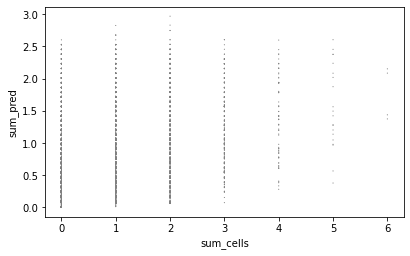

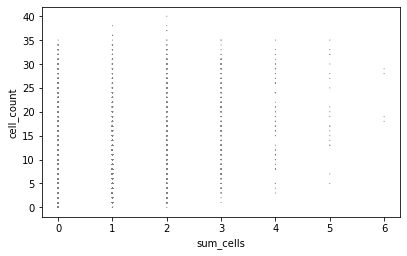

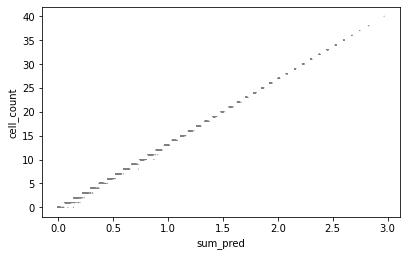

In [102]:
adata_st.obs.columns

ct_count = adata_st.obsm["tangram_ct_count"].iloc[:,4:]

nC = ct_count.sum(axis = 1)
adata_st.obs["sum_cells"] = nC
nP = adata_st.obsm["tangram_ct_pred"].sum(axis = 1)
adata_st.obs["sum_pred"] = nP
adata_st.obs["cell_n_tangram"] = adata_st.obsm["tangram_ct_count"]["cell_n"]

sc.pl.scatter(adata_st, "sum_cells", "sum_pred")
sc.pl.scatter(adata_st, "sum_cells", "cell_count")
sc.pl.scatter(adata_st, "sum_pred", "cell_count")
#sc.pl.scatter(adata_st, "cell_n_tangram", "cell_count")

The predictions are just up to 3 cells per spot even if the number of predicted celltypes is much higher. Check if it is using the positions in the spots as well, that were all the same.

In [88]:
adata_st.obsm["tangram_ct_pred"]
adata_st.obs["quantile_ncells"] = pd.qcut(adata_st.obs['sum_cells'], q=10, duplicates = 'drop').astype("category")

adata_st.obs["binned_ncells"] = pd.cut(adata_st.obs['sum_cells'], bins=10).astype("category")


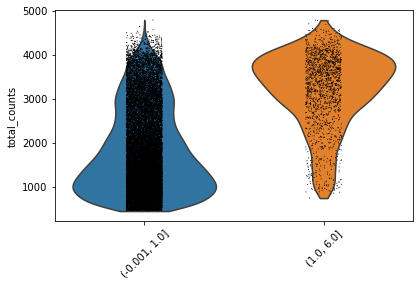

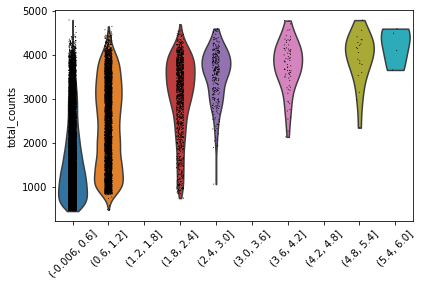

In [89]:
sc.pl.violin(adata_st,"total_counts", "quantile_ncells", rotation=45)
sc.pl.violin(adata_st,"total_counts", "binned_ncells", rotation=45)

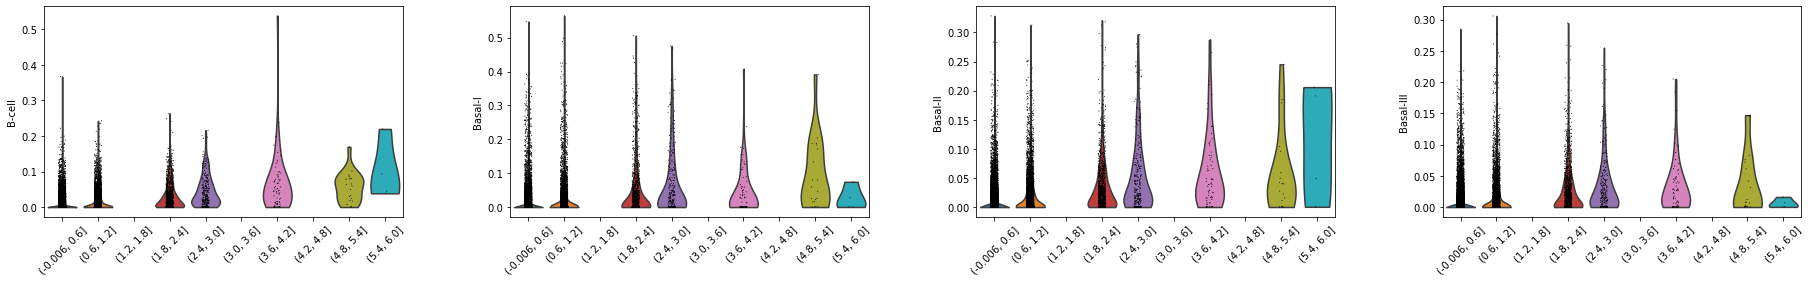

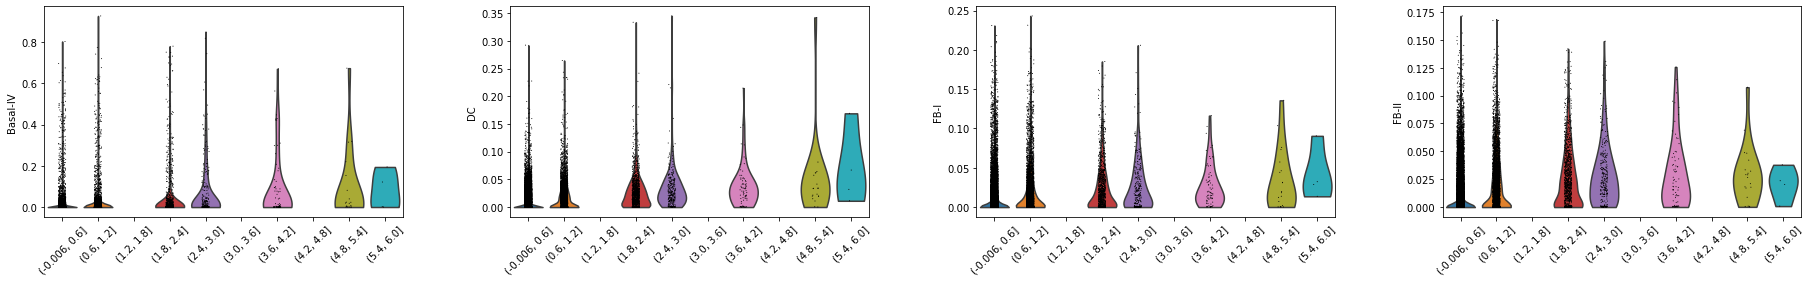

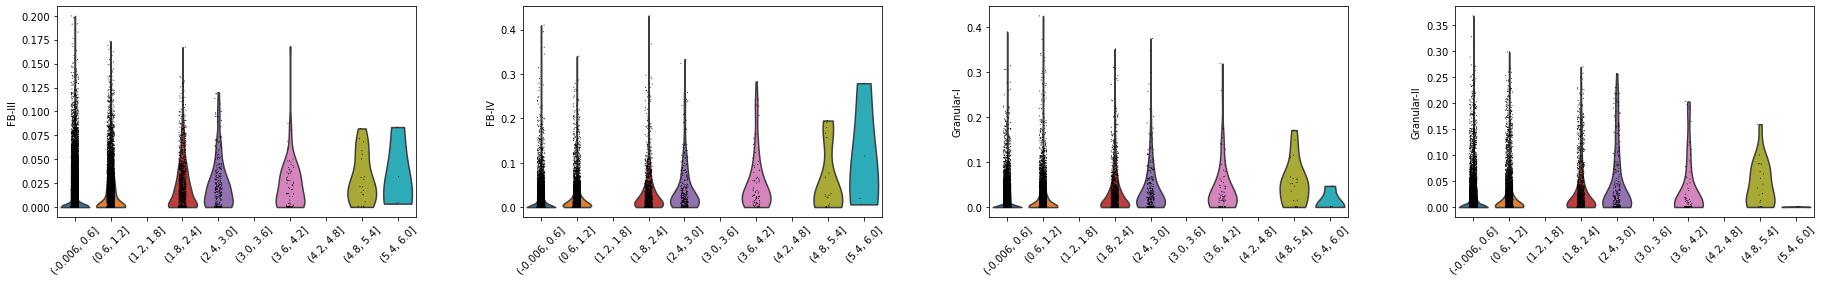

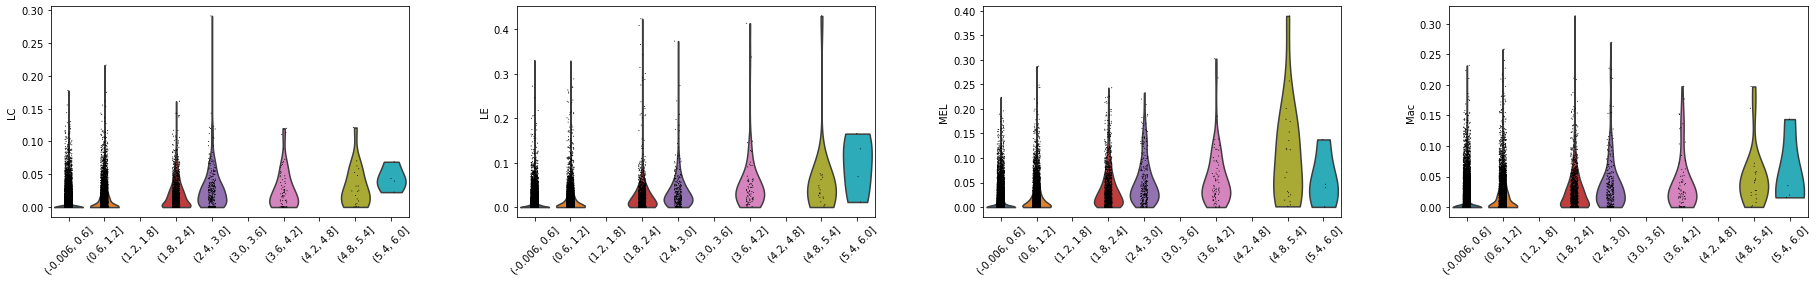

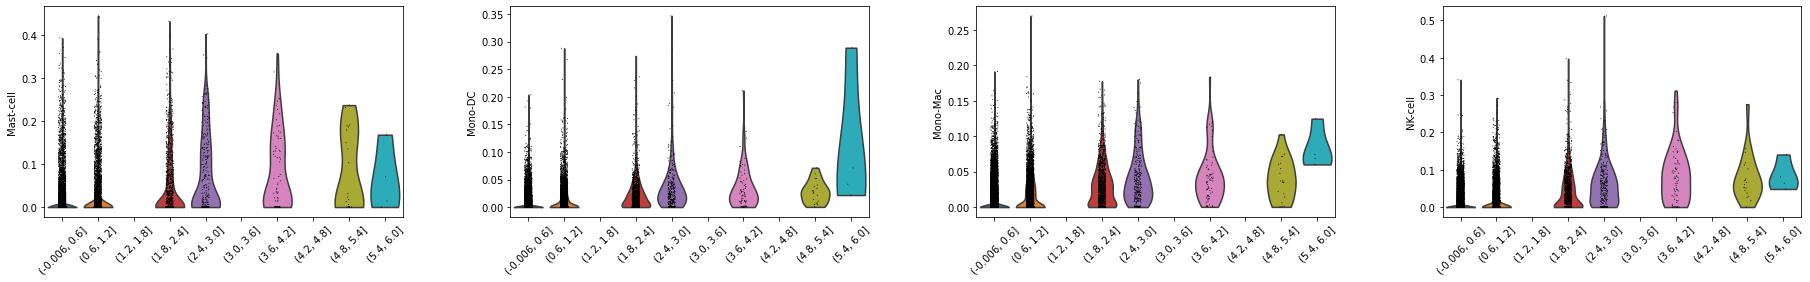

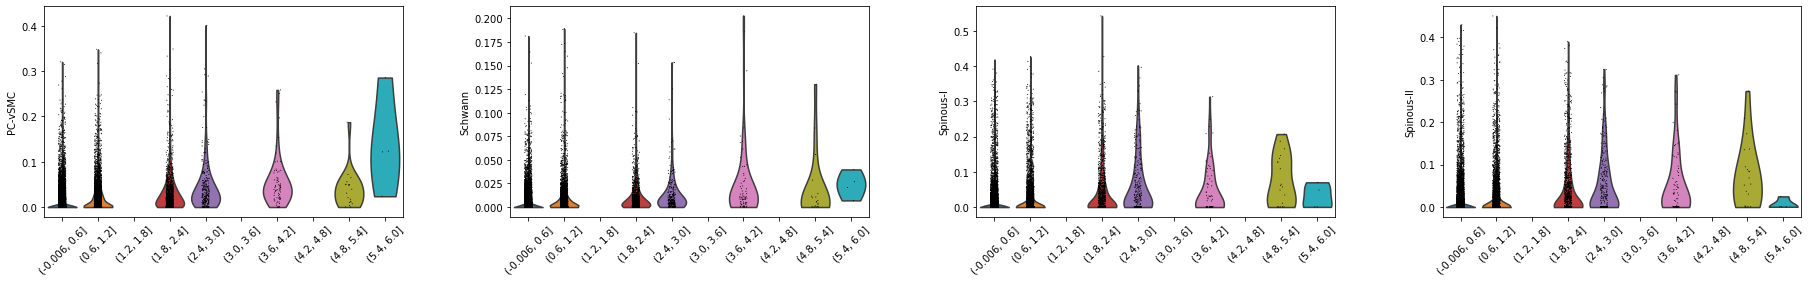

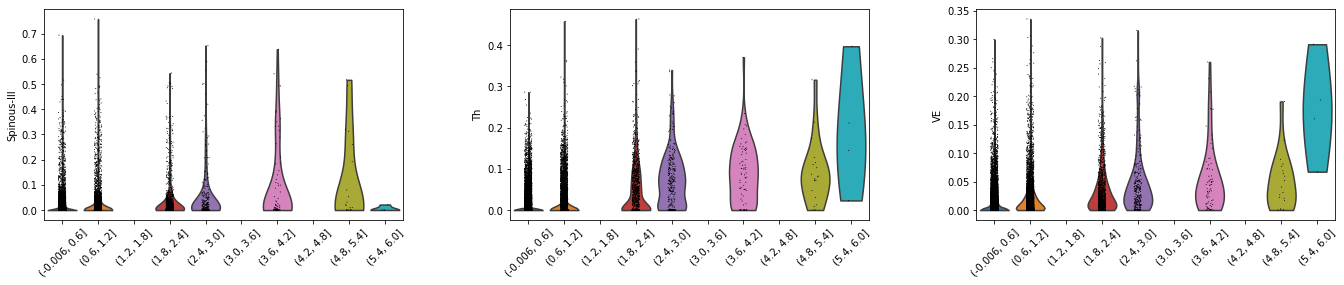

In [90]:
# plot each celltype by number of cells per spot


sc.pl.violin(adata_st,celltypes[:4], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[4:8], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[8:12], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[12:16], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[16:20], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[20:24], "binned_ncells", rotation=45)
sc.pl.violin(adata_st,celltypes[24:], "binned_ncells", rotation=45)

In [103]:
ct_count.sum(axis=0).sort_values()


Schwann        136
Mono-DC        235
LC             237
LE             283
Basal-IV       286
Basal-III      290
B-cell         292
DC             312
FB-I           352
Spinous-III    364
NK-cell        366
Basal-II       366
Mac            367
FB-III         367
Spinous-II     367
FB-IV          367
Basal-I        368
PC-vSMC        368
Granular-I     373
MEL            374
Spinous-I      374
FB-II          376
Th             376
Mono-Mac       378
Granular-II    380
Mast-cell      381
VE             385
dtype: int64